# Setup

In [2]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [5]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [6]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [8]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib notebook

# Import paths

In [10]:
def print_list(l):
    for item in l:
        print(item)

In [15]:
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = 'plane1/stat.npy'
pathSuffixToOps = 'plane1/ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:2]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:2]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D7
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Vale

# Import data

In [17]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36, 36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 2 stat files into class as self.statFiles. Total number of ROIs: 5249. Number of ROI from each file: [2451, 2798]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]


Converted 2 spatial footprint files into small centered images in self.ROI_images.
Imported 2 FOV images into class as self.FOV_images
Imported 2 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


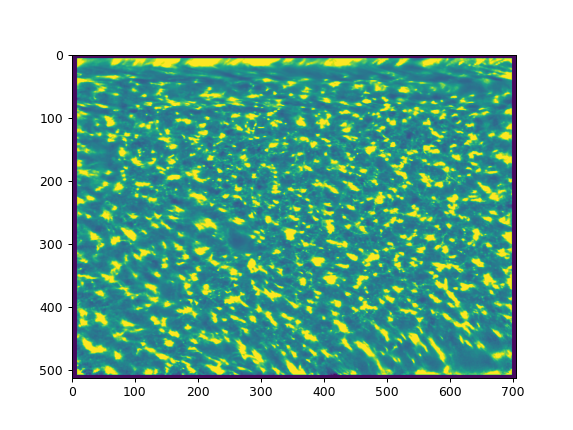

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [19]:
visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [20]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.72s/it]


<IPython.core.display.Javascript object>


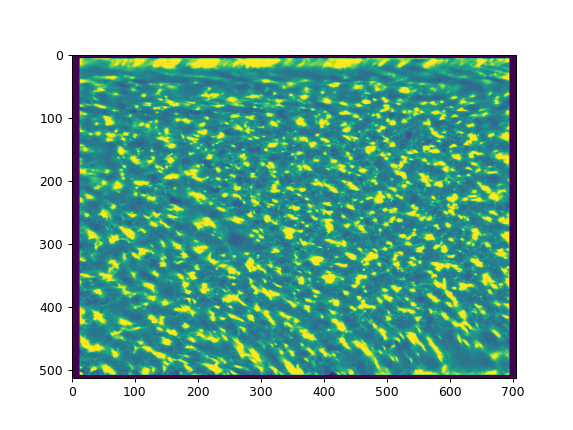

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


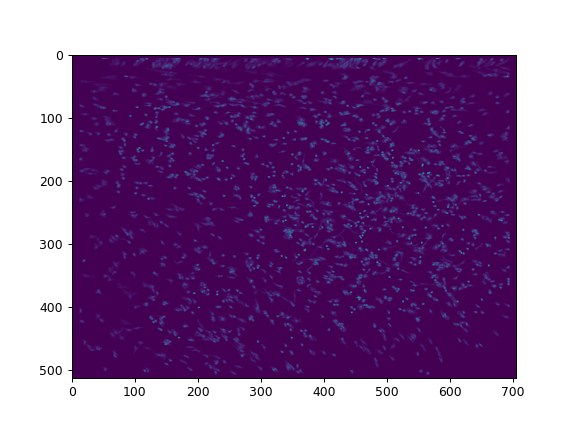

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [21]:
visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

<IPython.core.display.Javascript object>


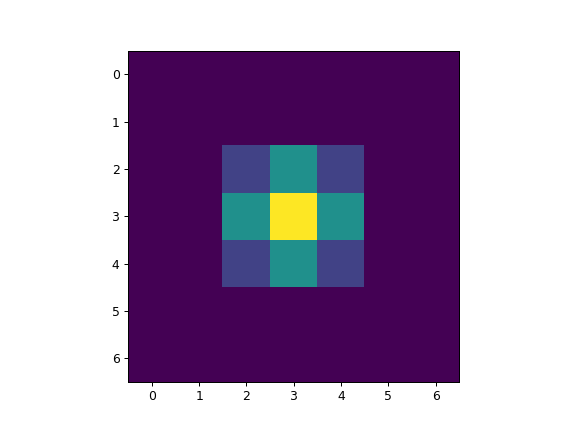

In [22]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2.0,
    device='cpu',
    plot_kernel=True
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=2000,
);

<IPython.core.display.Javascript object>


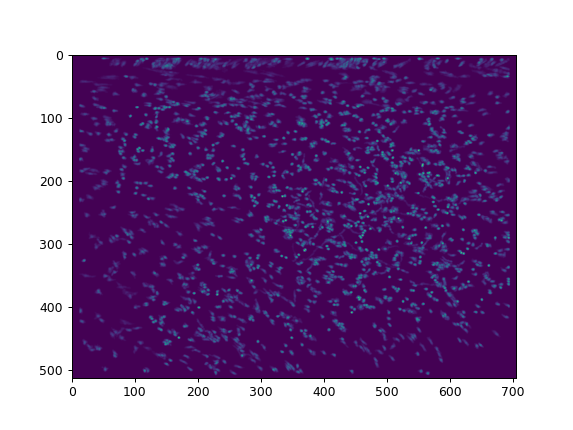

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [23]:
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [24]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    goal_size=250,
    ptile_norm=90,
    scale_norm=0.6,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
)

roinet.generate_latents();

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.65it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                   | 0/657 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [25]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [26]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=(36,36), 
    device='cuda:0'
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

SWT initialized
Starting: SWT transform on ROIs
Completed: SWT transform on ROIs


## Compute similarities

In [27]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1,
    verbose=True,
)

<IPython.core.display.Javascript object>


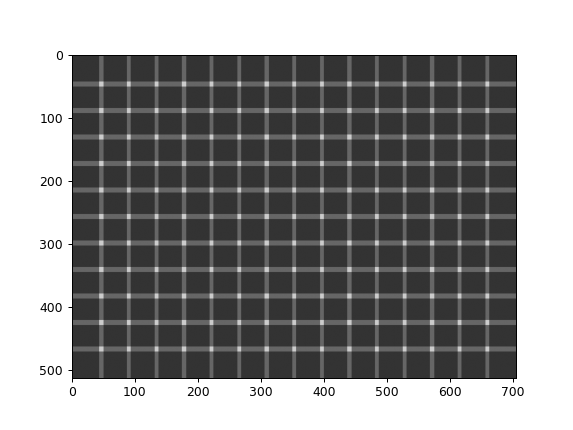

In [28]:
sim.visualize_blocks()

In [32]:
sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=helpers.bounded_logspace(0.05, 2, 50),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=300,
);

sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='mean',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='mean',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

sim.compute_cluster_scores(
    power_clusterSize=2, 
    power_clusterSilhouette=1.5
);

Computing pairwise similarity between ROIs...


100%|█████████████████████████████████████████| 192/192 [02:00<00:00,  1.60it/s]


Removing duplicate clusters...
Starting: Making cluster spatial footprints
Completed: Making cluster spatial footprints
Starting: Computing cluster similarities


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:647: RuntimeWarning: divide by zero encountered in true_divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:647: RuntimeWarning: divide by zero encountered in true_divide
  func_data = self.func(*func_args, dtype=self.dtype, **self.kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/sparse/_umath.py:541: RuntimeWarning: invalid value encountered in true_divide
  fill_value_array = self.func(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clus

Completed: Computing cluster similarities
Starting: Computing modified cluster silhouettes


100%|██████████████████████████████████████| 2246/2246 [00:06<00:00, 330.67it/s]

Completed: Computing modified cluster silhouettes


### look at results of similarity computations

<IPython.core.display.Javascript object>


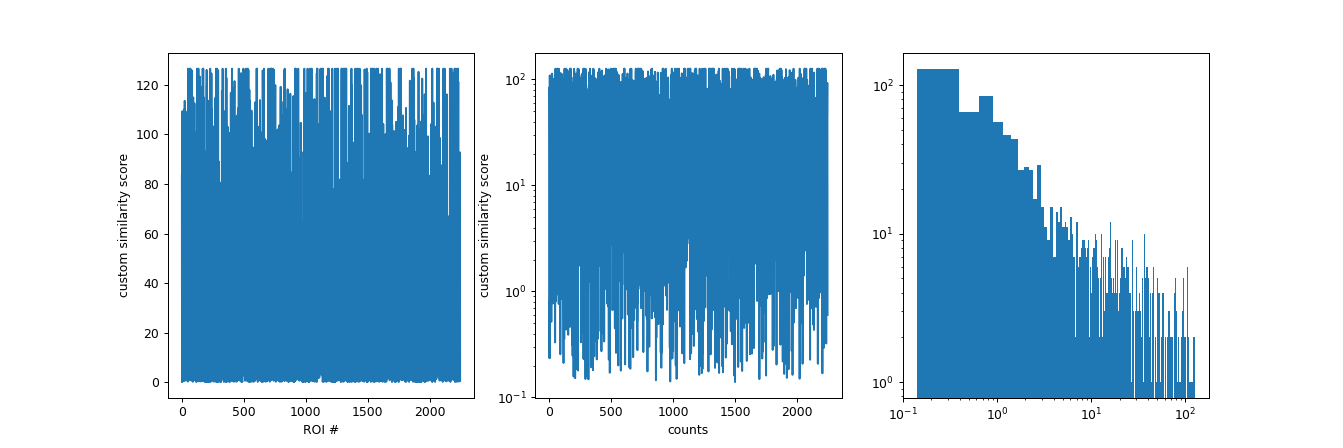

In [43]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(sim.scores.cpu())
axs[0].set_xlabel('ROI #')
axs[0].set_ylabel('custom similarity score')

axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')
axs[1].set_xlabel('ROI #')
axs[1].set_ylabel('custom similarity score')

axs[2].hist(sim.scores.cpu(), 500)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[1].set_xlabel('counts')
axs[1].set_ylabel('custom similarity score');

<IPython.core.display.Javascript object>


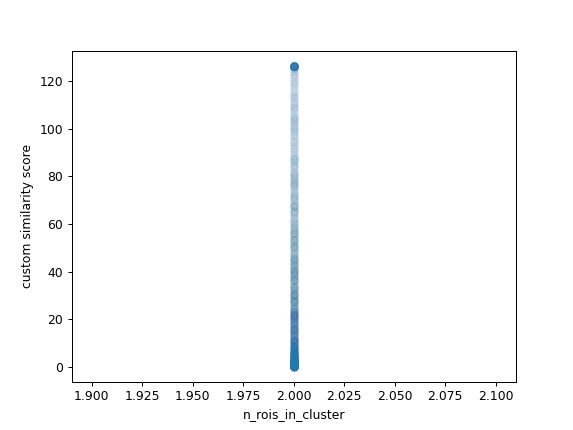

In [44]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()), sim.scores, alpha=0.01)
plt.xlabel('n_rois_in_cluster')
plt.ylabel('custom similarity score');

# Assign optimal clusters

In [49]:
clusterAssigner = cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device='cuda:0',
    m_init=(torch.ones(sim.c_sim.shape[0])*-5 + torch.rand(sim.c_sim.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=3e0, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 150, 'threshold': 50},
    sampleWeight_penalty=1e3,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e2,
    maskL1_penalty=2e-4,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [56]:
clusterAssigner.fit(
    min_iter=1e3,
    max_iter=50e3,
    verbose=True, 
    verbose_interval=100
)

iter: 5100:  loss_total: 39.6357  lr: 1.21260   loss_cs: 0.3788  loss_fracWeighted: 38.9374  loss_sampleWeight: 0.0537  loss_maskL1: 0.2658  diff_loss: -0.0059  loss_smooth: 39.6389
iter: 5200:  loss_total: 39.6092  lr: 2.41220   loss_cs: 0.3806  loss_fracWeighted: 38.9075  loss_sampleWeight: 0.0542  loss_maskL1: 0.2670  diff_loss: -0.0247  loss_smooth: 39.6271
iter: 5300:  loss_total: 39.5523  lr: 2.38820   loss_cs: 0.3832  loss_fracWeighted: 38.8465  loss_sampleWeight: 0.0543  loss_maskL1: 0.2683  diff_loss: -0.0337  loss_smooth: 39.5630
iter: 5400:  loss_total: 39.5245  lr: 1.18860   loss_cs: 0.3847  loss_fracWeighted: 38.8159  loss_sampleWeight: 0.0545  loss_maskL1: 0.2694  diff_loss: -0.0040  loss_smooth: 39.5305
iter: 5500:  loss_total: 39.5096  lr: 0.01300   loss_cs: 0.3849  loss_fracWeighted: 38.8005  loss_sampleWeight: 0.0546  loss_maskL1: 0.2696  diff_loss: -0.0089  loss_smooth: 39.5113
iter: 5600:  loss_total: 39.4997  lr: 1.21260   loss_cs: 0.3853  loss_fracWeighted: 38.790

iter: 9700:  loss_total: 38.9655  lr: 2.41220   loss_cs: 0.4162  loss_fracWeighted: 38.2023  loss_sampleWeight: 0.0585  loss_maskL1: 0.2885  diff_loss: -0.0036  loss_smooth: 38.9678
iter: 9800:  loss_total: 38.9362  lr: 2.38820   loss_cs: 0.4184  loss_fracWeighted: 38.1694  loss_sampleWeight: 0.0587  loss_maskL1: 0.2897  diff_loss: -0.0200  loss_smooth: 38.9429
iter: 9900:  loss_total: 38.9312  lr: 1.18860   loss_cs: 0.4195  loss_fracWeighted: 38.1631  loss_sampleWeight: 0.0586  loss_maskL1: 0.2900  diff_loss: -0.0062  loss_smooth: 38.9328
iter: 10000:  loss_total: 38.9162  lr: 0.01300   loss_cs: 0.4203  loss_fracWeighted: 38.1467  loss_sampleWeight: 0.0587  loss_maskL1: 0.2905  diff_loss: -0.0020  loss_smooth: 38.9176
iter: 10100:  loss_total: 38.9012  lr: 1.21260   loss_cs: 0.4214  loss_fracWeighted: 38.1298  loss_sampleWeight: 0.0588  loss_maskL1: 0.2911  diff_loss: -0.0080  loss_smooth: 38.9064
iter: 10200:  loss_total: 38.8952  lr: 2.41220   loss_cs: 0.4221  loss_fracWeighted: 38.

<IPython.core.display.Javascript object>


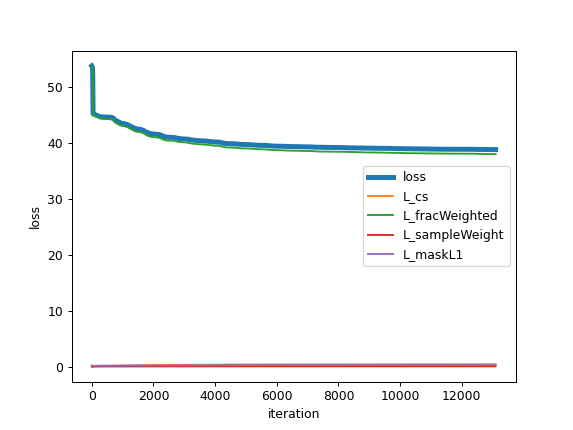

In [58]:
clusterAssigner.plot_loss()

In [59]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


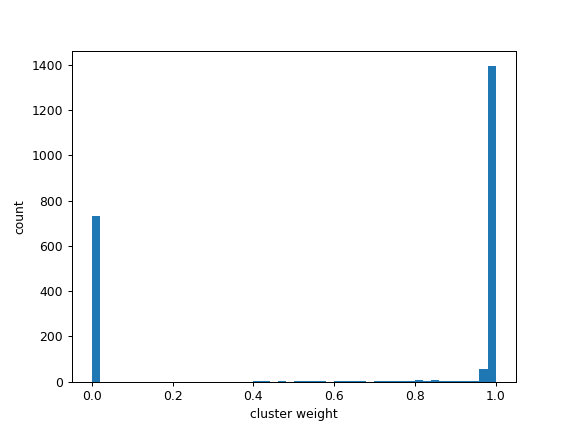

<IPython.core.display.Javascript object>


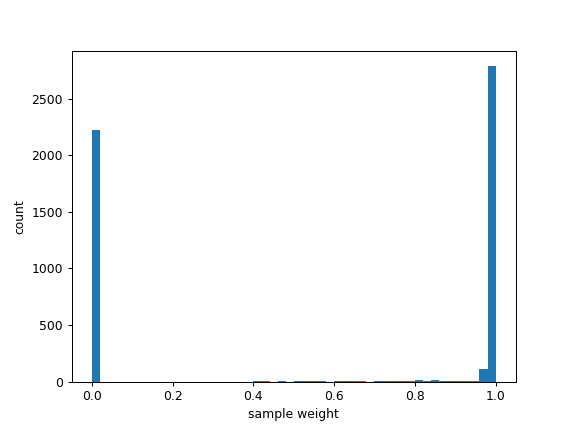

<IPython.core.display.Javascript object>


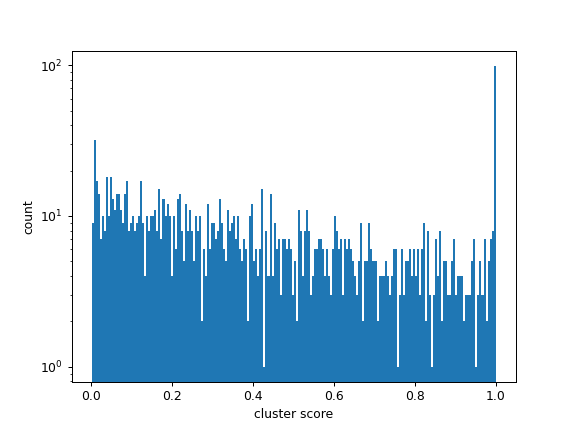

<IPython.core.display.Javascript object>


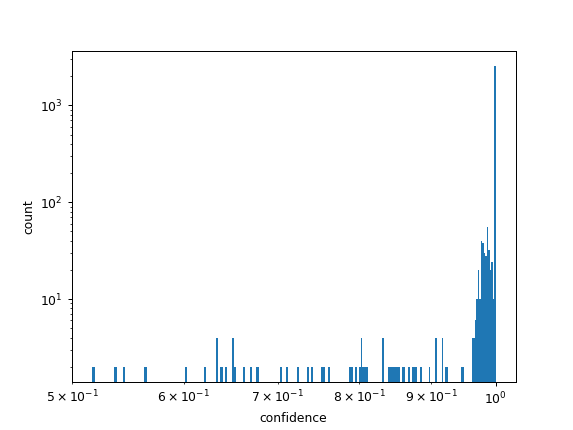

In [60]:
clusterAssigner.plot_clusterWeights()

clusterAssigner.plot_sampleWeights()

clusterAssigner.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

<IPython.core.display.Javascript object>


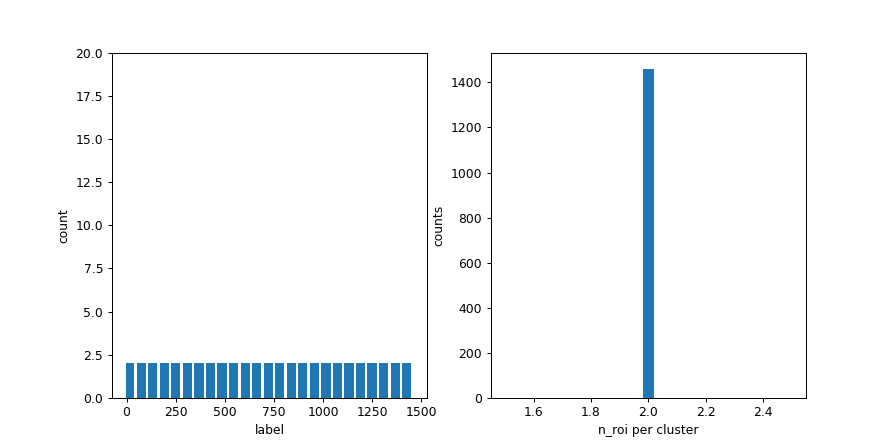

Number of clusters: 1458


In [61]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=m_threshold)

fig, axs = clusterAssigner.plot_labelCounts()
axs[0].set_ylim([0,20])

print(f'Number of clusters: {m_bool.sum()}')

# Visualize results

<IPython.core.display.Javascript object>


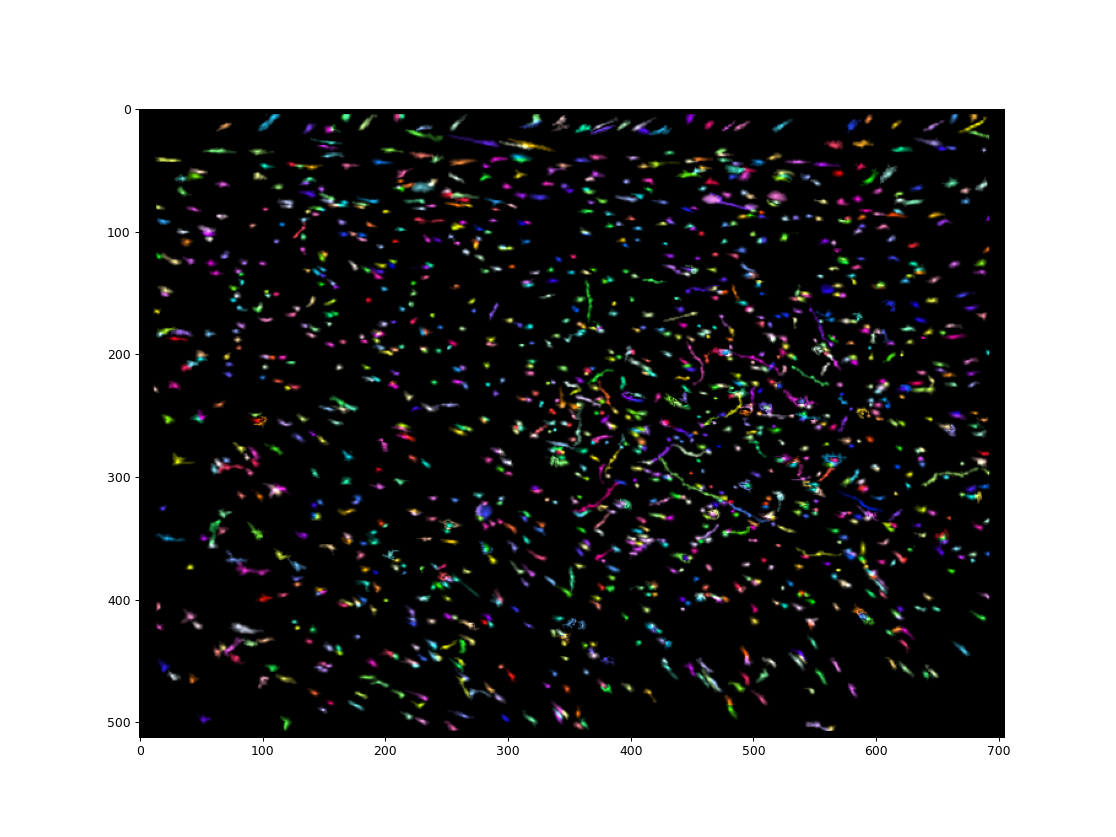

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [62]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=clusterAssigner.preds,
    confidence=clusterAssigner.confidence,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)

# Save results

In [ ]:
preds_by_session = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

pickle_helpers.simple_save(
    {
        "UCIDs": list(clusterAssigner.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_bySession,
        "ROIs": ROIs,
    },
    filename=dir_save / (name_save + '.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)